# A (Super-)Gentle Introduction to Markov Chain Monte Carlo (MCMC) --- Part I

**Notes**

*   Throughout the notebook made use of hyperlinks to definitions (e.g., from wikipedia, textbooks, other courses, papers and blogs)
*   Please always integrate with lecture notes and readings
*   References: O. Martin, Bayesian Analysis with Python, 2018, Chap. 8 (BRDS course bibliography)[https://cfteach.github.io/brds/referencesmd.html]


## Monte Carlo

"[Monte Carlo methods, or Monte Carlo experiments](https://en.wikipedia.org/wiki/Monte_Carlo_method), are a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. The underlying concept is to use randomness to solve problems that might be deterministic in principle." 


Simple example: calculate $\pi$ with Monte Carlo methods

In [1]:
import numpy as np 
# generate uniformly random points within a square of radius 2R with R=1

N = 5000 #points 

points = np.random.uniform(-1,1, (N,2))


In [2]:
inside = (np.sqrt(points[:, 0]**2+ points[:, 1]**2)<1)

res = inside.sum()

ratio = res / N 

approx_pi = 4*ratio 

print(approx_pi)

3.196


In [3]:
import matplotlib.pyplot as plt



In [4]:
figure = plt.figure(figsize=(12,12))

<Figure size 864x864 with 0 Axes>

(-1.25, 1.25)

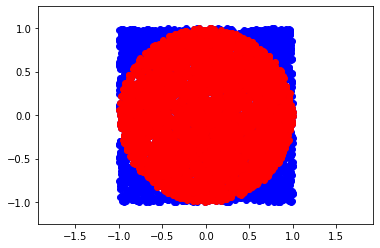

In [5]:
plt.plot(points[:,0],points[:,1],'o', color='blue')
plt.plot(points[inside][:,0],points[inside][:,1],'o', color='red')

plt.axis('equal')
plt.xlim(-1.25,1.25)
plt.ylim(-1.25,1.25)


## Markov Chain + Monte Carlo = MCMC 

"A [Markov chain or Markov process](https://en.wikipedia.org/wiki/Markov_chain) is a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. Informally, this may be thought of as, *'What happens next depends only on the state of affairs now'*."

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Markovkate_01.svg/260px-Markovkate_01.svg.png" alt="alternatetext">


*The defining characteristic of a Markov chain is that no matter how the process arrived at its present state, the possible future states are fixed. In other words, the probability of transitioning to any particular state is dependent solely on the current state and hence they are referred to a ["Memoryless"](https://wiki.ubc.ca/Course:CPSC522/Markov_Chains). Markov Chains can be modeled as a finite state machine that shows how a system transitions from one state to another and with what probability.*

- The condition of **detailed balance** of a Markov chain says that we should move in a reversible way, meaning the probability of moving from state $i$ to state $j$ is the same of moving from state $j$ to state $i$. This condition is used as a guide to design our MCMC, see later.


"[Markov chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) methods comprise a class of algorithms for sampling from a probability distribution. By constructing a Markov chain that has the desired distribution as its equilibrium distribution, one can obtain a sample of the desired distribution by recording states from the chain."

- MCMC algorithms are all constructed to have a stationary distribution. However, we require extra conditions to ensure that they converge to such distribution. Please see concept of [ergodicity](https://projecteuclid.org/journals/annals-of-applied-probability/volume-16/issue-3/On-the-ergodicity-properties-of-some-adaptive-MCMC-algorithms/10.1214/105051606000000286.full), starting from a simpler definition [here](https://en.wikipedia.org/wiki/Ergodicity).




When doing probabilistic programming through PyMC, we have been using sampling techniques without knowing it. We will focus on some of the details of these inference engines.

## Metropolis-Hastings Algorithm 



1.   Choose an initial value for the parameter $x_i$
2.   Choose a new $x_{i+1}$ by sampling from an easy-to-sample PROPOSAL (aka TRIAL) DISTRIBUTION (dubbed $q$) that allow to do the transition from $q(x_{i+1}|x_{i})$. This is a sort of perturbation from the state $x_{i}$ to $x_{i+1}$
3. Accept the new proposed state? The Metropolis-Hastings criterion is: 


$p(x_{i+1}|x_{i}) = min\{1,\frac{p(x_{i+1})q(x_{i}|x_{i+1})}{p(x_{i})q(x_{i+1}|x_{i})}\}$

4. If the probability of point 3 is larger than the value taken from a uniform distribution between [0,1], then accept the new state; otherwise, remain in the old state

5. Iterate from step 2 until we have "enough" samples. 

    --- we will see later convergence criteria --- 

Notice that if $q(x_{i}|x_{i+1})=q(x_{i+1}|x_{i})$ (detailed balance) we get the Metropolis criterion (drop the Hastings part), and get: 

$p(x_{i+1}|x_{i}) = min\{1,\frac{p(x_{i+1})}{p(x_{i})}\}$

      take a minute to make sense of this formula 



In [6]:
def metropolis(func, draws=10000):

  trace = np.zeros(draws)
  old_x = 0.5 #starting point 
  old_prob = func.pdf(old_x)

  delta = np.random.normal(0,0.5,draws) #trial distribution 

  for i in range(draws):
    new_x = old_x + delta[i]
    new_prob = func.pdf(new_x) 
    acceptance = new_prob/old_prob

    if(acceptance>np.random.uniform(0,1)):
      trace[i] = new_x 
      old_x = new_x 
      old_prob = new_prob 
    else:
      trace[i] = old_x # remain in the same state 

  return trace 

Now another (very) simple problem. MCMC of a beta function (yes, we already know its pdf... if you are thinking 'what's the point?', we are just introducing the mechanism of the MCMC sampling with a concrete simple implementation). 



/var/folders/r2/_2532dgx683084s9v9ss0cfc0000gq/T/ipykernel_63916/3565162428.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C1" (-> color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)). The keyword argument will take precedence.
  plt.plot(x,y,'C1',lw=3,label='True Distribution',color='red')


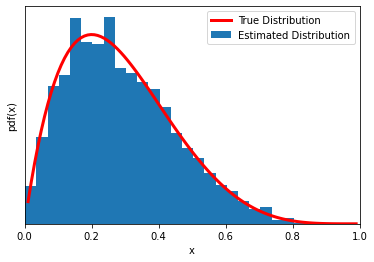

In [7]:
import scipy.stats as stats

np.random.seed(123)
#--- results from mcmc 
func = stats.beta(2,5)
trace = metropolis(func=func) 
#--- for plotting the true pdf for comparison 
x = np.linspace(0.01,0.99,100)
y = func.pdf(x)
#---
plt.xlim(0,1)
plt.plot(x,y,'C1',lw=3,label='True Distribution',color='red') 
plt.hist(trace[trace>0],bins=25, density=True, label='Estimated Distribution')
plt.xlabel('x')
plt.ylabel('pdf(x)')
plt.yticks([])
plt.legend()


What is Bayesian in all this? 
Make connection to what we have done so far for inferential problems using PyMC. (Notes in class)

After remembering this connection (real-world problems, not like the above), hopefully you are now fully appreciating the power of MCMC...  

p.s. please remember MCMC methods may take some time before they start getting samples from the target distribution -- burn-in period 